In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch 
from torch.autograd import Variable 
from matplotlib import pyplot as plt
import time
from statistics import mean

In [2]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [3]:
# Read in data from small csv to a dataframe
df1=pd.read_csv('weather_large.csv', sep=',')

# Reformat data in date/time column 
df1['Formatted Date'] =  pd.to_datetime(df1['Formatted Date'])

# Create a new column for year / month / hour
df1['Year'] = pd.DatetimeIndex(df1['Formatted Date']).year
df1['Month'] = pd.DatetimeIndex(df1['Formatted Date']).month
df1['Hour'] = pd.DatetimeIndex(df1['Formatted Date']).hour

# Encode month and hour for cyclical nature
df1 = encode(df1, 'Month', 13)
df1 = encode(df1, 'Hour', 23)
df1 = encode(df1, 'Wind Bearing (degrees)', 359)

# Remove original date/time column
df1=df1.drop(['Formatted Date'],axis=1)

# Convert columns to factors
df1['Summary'] = df1['Summary'].astype('category')
df1['Precip Type'] = df1['Precip Type'].astype('category')
df1['Daily Summary'] = df1['Daily Summary'].astype('category')

# Create a column stating whether its mostly cloudy / overcast or not in summary
df1['Heavy_Cloud'] = pd.np.where(df1.Summary.str.contains("Mostly Cloudy"), 1,
                    pd.np.where(df1.Summary.str.contains("Overcast"), 1,
                    pd.np.where(df1.Summary.str.contains("Foggy"), 1,0)))

# Convert to boolean and print count
df1['Heavy_Cloud']=df1['Heavy_Cloud'].astype('bool')

In [4]:
y = df1['Apparent Temperature (C)']
X=df1['Temperature (C)']

num = len(df1)
indices = list(range(num))
split = int(max(indices)*0.1)

test_idx = np.random.choice(indices, size=split, replace=False)

inter_idx = list(set(indices) - set(test_idx))

x_test=X[test_idx]
y_test=y[test_idx]

num = len(inter_idx)
indices = list(range(num))
split = int(max(indices)*0.22)

valid_idx = np.random.choice(inter_idx, size=split, replace=False)
train_idx = list(set(inter_idx) - set(valid_idx))

x_valid=X[valid_idx]
y_valid=y[valid_idx]

x_train = np.array(X[train_idx], dtype=np.float32)
x_train = x_train.reshape(-1, 1)

y_train = np.array(y[train_idx], dtype=np.float32)
y_train = y_train.reshape(-1, 1)

x_valid = np.array(X[valid_idx], dtype=np.float32)
x_valid = x_valid.reshape(-1, 1)

y_valid = np.array(y[valid_idx], dtype=np.float32)
y_valid = y_valid.reshape(-1, 1)

x_test = np.array(X[test_idx], dtype=np.float32)
x_test = x_test.reshape(-1, 1)

y_test = np.array(y[test_idx], dtype=np.float32)
y_test = y_test.reshape(-1, 1)

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df1),2),
                                                       round(len(y_valid)/len(df1),2),
                                                       round(len(y_test)/len(df1),2)))

train: 0.7% | validation: 0.2% | test 0.1%


In [5]:
# Create class
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)  

    def forward(self, x):
        out = self.linear(x)
        return out
    
input_dim = 1
output_dim = 1

model = LinearRegressionModel(input_dim, output_dim)

criterion = nn.MSELoss()

learning_rate = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10000
start_time = time.clock()
for epoch in range(epochs):
    epoch += 1
    # Convert numpy array to torch Variable
    inputs = torch.from_numpy(x_train).requires_grad_()
    labels = torch.from_numpy(y_train)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad() 

    # Forward to get output
    outputs = model(inputs)

    # Calculate Loss
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    # print('epoch {}, loss {}'.format(epoch, loss.item()))
print (time.clock() - start_time, "seconds")

21.182295 seconds


In [6]:
# Get predictions
predictions = model(torch.from_numpy(x_valid).requires_grad_()).data.numpy()

SSE=np.sum(np.power(y_valid-predictions,2))
y_mean=np.sum(y_valid)/len(y_valid)
SST=np.sum(np.power(y_valid-y_mean,2))
coef1=1-(SSE/SST)

print ('Coefficient of determination of the prediction on validation data:',coef1)
print('Mean Absolute Error on validation data:',sum(abs(y_valid-predictions))/len(y_valid))
print('Mean Squared Error on validation data:', sum(np.power(y_valid-predictions,2))/len(y_valid))
print('Root Mean Squared Error on validation data:', np.sqrt(sum(np.power(y_valid-predictions,2))/len(y_valid))) 

# Get predictions
predictions_test = model(torch.from_numpy(x_test).requires_grad_()).data.numpy()

SSE=np.sum(np.power(y_test-predictions_test,2))
y_mean=np.sum(y_test)/len(y_test)
SST=np.sum(np.power(y_test-y_mean,2))
coef2=1-(SSE/SST)

print ('Coefficient of determination of the prediction on test data:',coef2)
print('Mean Absolute Error on test data:',sum(abs(y_test-predictions_test))/len(y_test))
print('Mean Squared Error on test data:', sum(np.power(y_test-predictions_test,2))/len(y_test))
print('Root Mean Squared Error on test data:', np.sqrt(sum(np.power(y_test-predictions_test,2))/len(y_test))) 

Coefficient of determination of the prediction on validation data: 0.9851139923557639
Mean Absolute Error on validation data: [0.99961996]
Mean Squared Error on validation data: [1.6992599]
Root Mean Squared Error on validation data: [1.3035567]
Coefficient of determination of the prediction on test data: 0.9852102417498827
Mean Absolute Error on test data: [1.0009357]
Mean Squared Error on test data: [1.722655]
Root Mean Squared Error on test data: [1.3124995]


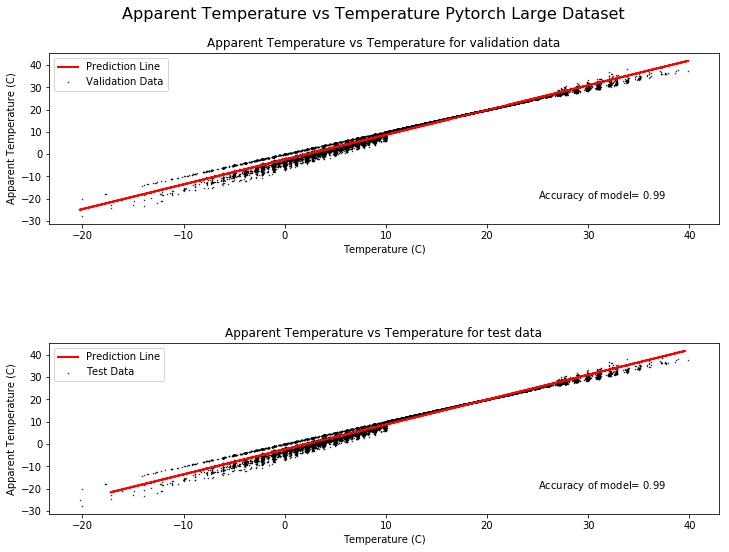

In [7]:
fig, (ax1,ax2) =plt.subplots(nrows=2,ncols=1,figsize=(12,8))

# Plot outputs of the actual validation data vs the prediction line
fig.suptitle('Apparent Temperature vs Temperature Pytorch Large Dataset', fontsize=16)

ax1.scatter(x_valid, y_valid, color='black', s=0.2,label='Validation Data')
ax1.plot(x_valid, predictions, color = 'r', linewidth=2,label='Prediction Line')
ax1.set_xlabel('Temperature (C)')
ax1.set_ylabel('Apparent Temperature (C)')
ax1.set_title('Apparent Temperature vs Temperature for validation data')
ax1.legend(loc=2)
textstr = 'Accuracy of model= $%.2f$'%(coef1)
ax1.text(25,-20,textstr)

# Plot outputs of the test data vs the prediction line

ax2.scatter(x_valid, y_valid, color='black', s=0.2,label='Test Data')
ax2.plot(x_test, predictions_test, color = 'r', linewidth=2,label='Prediction Line')
ax2.set_xlabel('Temperature (C)')
ax2.set_ylabel('Apparent Temperature (C)')
ax2.set_title('Apparent Temperature vs Temperature for test data')
ax2.legend(loc=2)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7,wspace=0.5)
textstr = 'Accuracy of model= $%.2f$'%(coef2)
ax2.text(25,-20,textstr)

fig.savefig('Linear_Regression_Large_PT.png',pdi=600)